In [172]:
import numpy as np
import pandas as pd
import qiime2 as q2

import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In many cases in we work with dependent data comprised of microbial profiles sampled over time. In order to account for this type of structure we use a LME model (using the REML method). As an example we will follow the q2-longitudinal tutorial using the ECAM dataset (https://docs.qiime2.org/2018.11/tutorials/longitudinal/). We will also use the first-distances generated in that tutorial (pairwise from previous time point). 


In [173]:
# import the metadata
mf = q2.Metadata.load('data/ecam-metadata.tsv').to_dataframe()
# import the alpha-diversity
alpha = q2.Artifact.load('data/ecam-first-distances.qza').view(q2.Metadata).to_dataframe()

# merge the two data values
data = pd.concat([alpha, mf], axis=1, sort=False)

data.head(10)


,Distance,antiexposedall,day_of_life,delivery,diet,diet_3,mom_child,month,month_of_life,sample_summary,sex,studyid
10249.C001.03SS,0.848675,n,42.0,Vaginal,bd,eb,C,1.0,1.4,Vaginal.bd.n.0,Female,1
10249.C002.02SS,0.618251,n,32.0,Cesarean,bd,eb,C,1.0,1.1,Cesarean.bd.n.1,Male,2
10249.C004.02SS,0.872569,n,31.0,Cesarean,bd,eb,C,1.0,1.0,Cesarean.bd.n.1,Male,4
10249.C005.03SS,0.814201,n,43.0,Cesarean,fd,fd,C,1.0,1.4,Cesarean.fd.n.1,Female,5
10249.C007.02SS,0.818699,n,30.0,Cesarean,bd,eb,C,1.0,1.0,Cesarean.bd.n.1,Male,7
10249.C008.02SS,0.693770,n,31.0,Vaginal,bd,eb,C,1.0,1.0,Vaginal.bd.n.0,Male,8
10249.C009.02SS,0.868335,n,31.0,Vaginal,bd,eb,C,1.0,1.0,Vaginal.bd.n.0,Male,9
10249.C010.03SS,0.500147,n,39.0,Vaginal,bd,eb,C,1.0,1.3,Vaginal.fd.n.0,Male,10
10249.C011.02SS,0.820382,n,36.0,Cesarean,fd,fd,C,1.0,1.2,Cesarean.fd.n.1,Female,11
10249.C012.02SS,0.565373,n,29.0,Cesarean,bd,eb,C,1.0,1.0,Cesarean.bd.n.1,Female,12


There are several measurements in this dataset but we will explore the birth mode effect. In the case of birth mode we want to set the "normal" group explicitly and treat the C-section birth as the "treatment" group. In order to transfer this to a formula we use the following notation:

```python
C(delivery, Treatment('Vaginal'))
```

Furthermore, we want to include the interaction of birth mode and time. This means we want to see if birth mode is discriminatory over all time or if there is an interaction with time. This gives us:

```python
Distance ~ month * C(delivery, Treatment('Vaginal'))
```


In [174]:
fml = "Distance ~ month * C(delivery, Treatment('Vaginal'))"
fml

"Distance ~ month * C(delivery, Treatment('Vaginal'))"

Now using statsmodel's LME implementation we will fit our model to the data.

In [175]:
md = sm.MixedLM.from_formula(fml, data,
                             groups = data["studyid"],
                             missing = 'drop')
mdf = md.fit(method = 'lbfgs')


/Users/cmartino/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


First we should visualize the residuals.

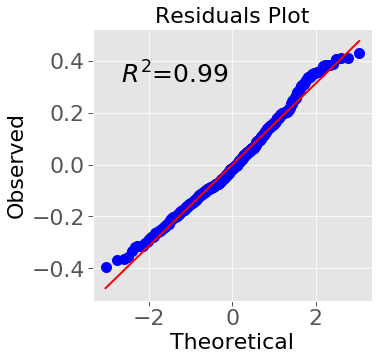

In [176]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

_, (__, ___, r) = sp.stats.probplot(mdf.resid, plot=ax, fit=True)
ax.annotate('$R^{2}$=%.2f'%(r**2), (.1,.8), fontsize=25
            ,xycoords = 'axes fraction')
ax.set_title('Residuals Plot',
             fontsize=22)
ax.set_xlabel('Theoretical',
             fontsize=22,
              c='black')
ax.set_ylabel('Observed',
              fontsize=22,
              c='black')
plt.show()

The $R^{2}$ value looks good so now we should explore the other measures of model quality.

In [177]:
mdf.summary().tables[0]

,0,1,2,3
0,Model:,MixedLM,Dependent Variable:,Distance
1,No. Observations:,583,Method:,REML
2,No. Groups:,42,Scale:,0.0248
3,Min. group size:,5,Likelihood:,233.1100
4,Max. group size:,20,Converged:,Yes
5,Mean group size:,13.9,,


 Let's look at the model results 

In [178]:
mdf.summary().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.445,0.015,30.472,0.000,0.416,0.473
"C(delivery, Treatment('Vaginal'))[T.Cesarean]",0.030,0.023,1.302,0.193,-0.015,0.076
month,-0.006,0.001,-4.639,0.000,-0.008,-0.003
"month:C(delivery, Treatment('Vaginal'))[T.Cesarean]",-0.004,0.002,-2.293,0.022,-0.008,-0.001
Group Var,0.000,0.001,,,,


From these results we get the fixed effect of birth mode against the dependent variable of pairwise distance. From this we first inspect the coefficients and notice that group variance is almost zero. If the group coefficient is high it may mean that we are not accounting for some variability in the data. Second we look at the estimated standard errors, z scores, p-values (P>|z|), and 95% confidence interval upper and lower bounds for each parameter. From these we can observe that the p-value for birth mode is not significant. However, the interaction of time and birth mode is significant. This means that there is some change between birth mode over time but not across all time. 

In order to explore this further we can visualize the birth mode distance over time.

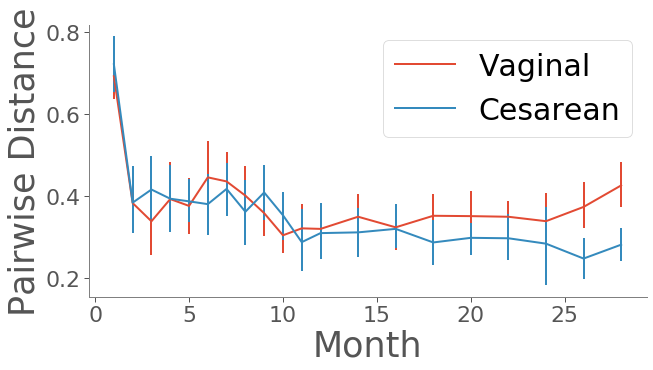

In [171]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 22 
plt.rcParams['ytick.labelsize'] = 22

fig, ax = plt.subplots(1,1, figsize=(10, 5))

sns.lineplot(x='month',
             y='Distance',
             hue='delivery',
             data = data,
             ax = ax,
             err_style = 'bars')

ax.set_xlabel('Month',fontsize=35)
ax.set_ylabel('Pairwise Distance',fontsize=35)

ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], labels[1:],
            prop={'size':30}, loc=2, 
            bbox_to_anchor=(.50, 1.0),
            fancybox=True, framealpha=0.8,ncol=1
            , markerscale=1.1, facecolor="white")

plt.show()

From this plot it is clear that we do have an interaction between birth mode over time and the pairwise distances because birth mode only separates after the 15th month of life. 